## Imports

In [2]:
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.instruction import Instruction
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info.states import Statevector
from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit_algorithms.optimizers import COBYLA, BFGS
from qiskit.primitives import Estimator

import numpy as np
from numpy.linalg import eig, norm
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from itertools import combinations, chain
from heapq import nsmallest

In [3]:
NUM_STATES_2_QUBITS = 4
NUM_MUBS_2_QUBITS = 5
NUM_STATES_3_QUITS = 8
NUM_MUBS_3_QUBTIS = 9

## Generate transverse-field Ising operator

I started by using the qiskit_nature.second_q module. That proved to be a mistake once I want to move to qubits,
because their move is not trivial.

The following is an implementation of the operators in SparsePauliOp form directly.

In [4]:
def gen_trans_ising_op(num_qubits: int, zz_coeff: float, x_coeff: float, toric_bounds: bool=False) -> SparsePauliOp:
    terms = []
    coeffs = []
    # Adding the ZZ terms
    for i in range(num_qubits if toric_bounds else num_qubits-1):
        curr_term = ['I'] * num_qubits
        curr_term[i] = 'Z'
        curr_term[(i+1)%num_qubits] = 'Z'
        terms.append(''.join(curr_term))
        coeffs.append(zz_coeff)
    # Adding the X terms
    for i in range(num_qubits):
        curr_term = ['I'] * num_qubits
        curr_term[i] = 'X'
        terms.append(''.join(curr_term))
        coeffs.append(x_coeff)
    
    return SparsePauliOp(terms, coeffs)

## Get exact answers

### A question of goals
In the origianl formulation, the goal of VQE is to find the lowest eigenvalue.
The tricky part is that numpy does not guarantee any ordering of the eigenvalues and eigenvectors. So that's on us.

In [5]:
def get_exact_ground(op: SparsePauliOp) -> np.float64:
    eig_res = eig(op.to_matrix())
    return min(eig_res.eigenvalues).real

## Get expectation value over specific state-vector

In [6]:
def get_expectation_value(state: Statevector, op: SparsePauliOp) -> np.float64:
    return np.round(state.expectation_value(op).real, 10)

## Generate MUB statevectors
This is done using Dekel's current notebook code.
I will attempt to prepare it later in a cleaner and more robust way.

In [7]:
# Adds Y-Hadamard gate on qubit q in circ
def yh(circ, q):
    circ.h(q)
    circ.s(q)

def prep_MUB(circ, state_idx, mub_idx, qubit_subset = [0,1]):
    assert len(qubit_subset) == 2
    assert (0 <= state_idx <= 3)
    assert (0 <= mub_idx <= 4)
    # state_idx chooses the state in the basis (MUB)
    if state_idx == 1:
        circ.x(qubit_subset[0])
    elif state_idx == 2:
        circ.x(qubit_subset[1])
    elif state_idx == 3:
        circ.x(qubit_subset[0])
        circ.x(qubit_subset[1])
        
    # mub_idx chooses the basis (MUB) itself
    if mub_idx == 1:
        circ.h(qubit_subset[0])
        circ.h(qubit_subset[1])
    elif mub_idx == 2:
        circ.h(qubit_subset[0])
        yh(circ,qubit_subset[1])
        circ.cz(qubit_subset[0], qubit_subset[1])
    elif mub_idx == 3:
        yh(circ,qubit_subset[0])
        yh(circ,qubit_subset[1])
    elif mub_idx == 4:
        yh(circ,qubit_subset[0])
        circ.h(qubit_subset[1])
        circ.cz(qubit_subset[0], qubit_subset[1])
        
def prep_MUB3(circ, state_idx, mub_idx, qubit_subset = [0,1,2]):
    # state_idx chooses the state in the basis (MUB)
    if state_idx == 1:
        circ.x(qubit_subset[0])
    elif state_idx == 2:
        circ.x(qubit_subset[1])
    elif state_idx == 3:
        circ.x(qubit_subset[0])
        circ.x(qubit_subset[1])
    elif state_idx == 4:
        circ.x(qubit_subset[2])
    elif state_idx == 5:
        circ.x(qubit_subset[0])
        circ.x(qubit_subset[2])
    elif state_idx == 6:
        circ.x(qubit_subset[1])
        circ.x(qubit_subset[2])
    elif state_idx == 7:
        circ.x(qubit_subset[0])
        circ.x(qubit_subset[1])
        circ.x(qubit_subset[2])
    
    # mub_idx chooses the basis (MUB) itself
    if mub_idx == 1:
        circ.h(qubit_subset[0])
        circ.h(qubit_subset[1])
        circ.h(qubit_subset[2])
    elif mub_idx == 2:
        yh(circ, qubit_subset[0])
        yh(circ, qubit_subset[1])
        yh(circ, qubit_subset[2])
    elif mub_idx == 3:
        yh(circ, qubit_subset[0])
        circ.h(qubit_subset[1])
        circ.h(qubit_subset[2])
        circ.cz(qubit_subset[1], qubit_subset[2])
        circ.cz(qubit_subset[0], qubit_subset[1])
    elif mub_idx == 4:
        circ.h(qubit_subset[0])
        yh(circ, qubit_subset[1])
        circ.h(qubit_subset[2])
        circ.cz(qubit_subset[1], qubit_subset[2])
        circ.cz(qubit_subset[0], qubit_subset[2])
    elif mub_idx == 5:
        circ.h(qubit_subset[0])
        circ.h(qubit_subset[1])
        yh(circ, qubit_subset[2])
        circ.cz(qubit_subset[0], qubit_subset[1])
        circ.cz(qubit_subset[0], qubit_subset[2])
    elif mub_idx == 6:
        yh(circ, qubit_subset[0])
        yh(circ, qubit_subset[1])
        circ.h(qubit_subset[2])
        circ.cz(qubit_subset[0], qubit_subset[1])
        circ.cz(qubit_subset[0], qubit_subset[2])
    elif mub_idx == 7:
        yh(circ, qubit_subset[0])
        circ.h(qubit_subset[1])
        yh(circ, qubit_subset[2])
        circ.cz(qubit_subset[1], qubit_subset[2])
        circ.cz(qubit_subset[0], qubit_subset[2])
    elif mub_idx == 8:
        circ.h(qubit_subset[0])
        yh(circ, qubit_subset[1])
        yh(circ, qubit_subset[2])
        circ.cz(qubit_subset[0], qubit_subset[1])
        circ.cz(qubit_subset[1], qubit_subset[2])

The field `state_idx` chooses the state *inside* the MUB.  
The field `mub_idx` chooses the basis.   
The field `qubit_subset` chooses the subset of qubit_subset over which to generate the MUB state.   

In [8]:
def generate_mub_state_circ(state_idx: int, mub_idx: int, num_qubits: int, qubit_subset: list[int],
                        plus_for_non_mub: bool) -> QuantumCircuit:
    circuit = QuantumCircuit(num_qubits)
    if len(qubit_subset) == 2:
        prep_MUB(circuit, state_idx, mub_idx, qubit_subset)
    elif len(qubit_subset) == 3:
        prep_MUB3(circuit, state_idx, mub_idx, qubit_subset)
    else:
        raise Exception("We do not support this size of MUB states.")
    if plus_for_non_mub:
        for qubit in range(num_qubits):
            if qubit not in qubit_subset:
                circuit.h(qubit)
    return circuit

# Attempt all states over a hamiltonian

## Result heirarchy
The list heirarchy is defined by the following indexes, in this order:
1. MUB used.
2. Subset of qubits on which this MUB was applied.
3. The specific MUB states.

In [9]:
def generate_all_subsets(n_mub_qubits: int, n_qubits: int) -> list[tuple[int]]:
    return list(combinations(np.linspace(0, n_qubits-1, n_qubits, dtype=int), n_mub_qubits))

In [10]:
ResultTuple = tuple[QuantumCircuit, np.float64]
LandscapeResultsType = list[list[list[ResultTuple]]]

def calculate_energy_landscape(op: SparsePauliOp, n_mub_qubits: int, subset_list: list[tuple],
                                appended_ansatz: QuantumCircuit | None = None,
                                plus_for_non_mub: bool = False) -> LandscapeResultsType:
    num_states = num_mubs = 0
    if n_mub_qubits == 2:
        num_states = NUM_STATES_2_QUBITS
        num_mubs = NUM_MUBS_2_QUBITS
    elif n_mub_qubits == 3:
        num_states = NUM_STATES_3_QUITS
        num_mubs = NUM_MUBS_3_QUBTIS
    else:
        raise Exception("We do not support this size of MUB states.")

    total_res = []
    for mub_idx in range(num_mubs):
        mub_res = []
        for subset in subset_list:
            subset_res = []
            for state_idx in range(num_states):
                circuit = generate_mub_state_circ(state_idx, mub_idx, op.num_qubits, subset, plus_for_non_mub)
                if appended_ansatz is not None:
                    final_circuit = circuit.compose(appended_ansatz, range(circuit.num_qubits), inplace=False)
                else:
                    final_circuit = circuit
                state = Statevector.from_instruction(final_circuit)
                res = get_expectation_value(state, op)
                subset_res.append((circuit, res))
            mub_res.append(subset_res)
        total_res.append(mub_res)
    return total_res

def flatten_results(results: LandscapeResultsType) -> list[ResultTuple]:
    flat_res = []
    for mub_res in results:
        for subset_res in mub_res:
            flat_res += subset_res
    return flat_res

def flatten_energies(results: LandscapeResultsType) -> list[np.float64]:
    flat_res = flatten_results(results)
    return [energy for circuit, energy in flat_res]

### Result Selection Code

In [11]:
def find_k_best_results(results: LandscapeResultsType, k: int) -> list[ResultTuple]:
    results = flatten_results(results)
    return sorted(results, key=(lambda x: x[1]))[:k]

## Graph display code

In [12]:
FIG_SIZE = (8,5)
def display_energy_landscape(energy_landscape_results: LandscapeResultsType, exact_result: np.float64, graph_title="Energy landscape",
                                show_legend=False):
    fig = plt.figure(figsize=FIG_SIZE)
    idx_counter = 0
    basis_size = len(results[0][0])
    mub_results_size = basis_size * len(results[0])
    for i, mub_res in enumerate(results):
        for j, subset_res in enumerate(mub_res):
            energies_only = [energy for circuit, energy in subset_res]
            plt.plot(list(range(idx_counter, idx_counter+basis_size)), energies_only, 'o', lw=0.4, label=f"MUB {i}, subset {j}")
            idx_counter += basis_size
        # Show separation between different MUBs
        plt.axvspan(idx_counter - mub_results_size, idx_counter, alpha=0.1, color=f"C{i}")
    # Show exact result
    plt.axhline(y=exact_result, lw=0.6, color='red')
    # Show comp. basis specifically
    xmin, xmax, ymin, ymax = plt.axis()
    plt.text(x=basis_size*0.25, y=ymin + (ymax-ymin)*0.8, s='COMP', fontsize=10)
    
    plt.xlabel("MUB state index")
    plt.ylabel("Cost function result")
    if show_legend:
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(graph_title)
    plt.show()

def display_energy_histogram(energy_landscape_results: LandscapeResultsType, exact_result: np.float64, bins=100,
                                graph_title="Energy landscape histogram", show_legend=False):
    fig = plt.figure(figsize=FIG_SIZE)
    plt.locator_params(axis='x', nbins=min(bins//2, 30), tight=True)
    plt.xticks(fontsize=10, rotation=60)
    plt.locator_params(axis='y', nbins=10)

    flat_results = flatten_energies(energy_landscape_results)
    plt.hist(flat_results, bins)
    # Show exact result
    plt.axvline(x=exact_result, lw=1, color='red')

    plt.xlabel("Cost function result")
    plt.ylabel("number of results")
    if show_legend:
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(graph_title)
    plt.show()

# Execute VQE
The Parameters class is taken from the old VQC project and adapted to this use case.

## Some thinking
If when I am creating the landscape I am already plugging the ansatz **into** the state, this might actually break....

Okay look.
I need to run the experiment with the ansatz plugged at the **front**, but also not just keep it attached during the dataflow.
the reason is this.

In order to get the landscape, I need to calculate it with a *concrete* instantiation of the ansatz. That is with a specific vector of thetas, which turns it to a "regular" circuit and not an ansatz that can be plugged into VQE.

That means that if I plug it into the `get_mub_state` method, I just get the non-parametric circuit, which is useless from that point forward.

This means that I must only attach an instance of the ansatz for the calculation, and not continue to propogate the appended version on and on.
This requires that I only get the circuit from `get_mub_state`, and generate the state inside the landscape method.


### Experiment Paremeters and Hyper-parameters

In [ ]:
from qiskit.quantum_info import Operator
ansatz = TwoLocal (
        params.n_qubits,
        ['ry','rz'],
        'crx',
        'linear',
        reps=params.n_layers
    )
print(Operator(ansatz.assign_parameters([0.0]*ansatz.num_parameters)).data)

In [33]:
class Parameters:
    def __init__(self, n_qubits: int, n_layers: int, optimizer: str,
                    tol: float, success_bound: float, max_iter: int,
                    report_period: int, report_thetas: bool,
                    exact_result: float | None = None):
        self.n_qubits = n_qubits            # number of qubist in the operator
        self.n_layers = n_layers            # number of ansatz layers
        self.optimizer = optimizer          # name of optimizer
        self.tol = tol                      # optimizer "tolerance" parameter. Semantic meaning differs between optimizers.
        self.success_bound = success_bound  # distance from exact result that we consider as success.
        self.max_iter = max_iter            # iteration bound
        self.report_period = report_period  # how many iterations before a callback print.
        self.report_thetas = report_thetas  # whether to show the paramneter vector at the callback print
        self.exact_result = exact_result    # the exact result that we compare ourselves to.


def get_standard_params(n_qubits: int) -> Parameters:
    return Parameters(n_qubits=n_qubits, n_layers=5, optimizer='COBYLA', tol=1e-6, success_bound=1e-3, max_iter=1000, report_period=20, report_thetas=False)

In [38]:
def run_vqe_experiment(hamiltonian: SparsePauliOp, ansatz: QuantumCircuit, initial_state: QuantumCircuit, params: Parameters) -> tuple[int, float, bool]:
    # preparing the VQE components
    estimator_obj = Estimator()  # Internal qiskit structure
    optimizer_obj = None
    if params.optimizer == 'COBYLA':
        optimizer_obj = COBYLA(
            maxiter = 1000, \
            tol = params.tol \
        )
    elif params.optimizer == 'BFGS':
        optimizer_obj = COBYLA(
            maxiter = 1000, \
            tol = params.tol \
        )
    else:
        raise Exception('Optimizer not supported in this experiment!~')
    ansatz_with_prepened_mub = initial_state.compose(ansatz, range(ansatz.num_qubits), inplace=False)
    # enforcing the success bound
    class BoundHitException(Exception):
        def __init__(self, n_evals, final_cost):
            self.n_evals = n_evals
            self.final_cost = final_cost
    def callback(eval_count: int, theta: np.ndarray, cost: float, metadata: dict) -> None:
        if params.exact_result is None:
            return
        if (eval_count % params.report_period == 0):
            print(f"{eval_count}: {cost}")
            if (params.report_thetas):
                print(f"thetas: {theta}")
        if (cost < params.exact_result + params.success_bound):
            raise BoundHitException(eval_count, cost)
    
    try:
        vqe_obj = VQE(estimator=estimator_obj, ansatz=ansatz_with_prepened_mub, optimizer=optimizer_obj, callback=callback, initial_point = [0.0]*ansatz.num_parameters)
        res = vqe_obj.compute_minimum_eigenvalue(operator=hamiltonian)
        return res.cost_function_evals, res.optimal_value, False
    except BoundHitException as e:
        return e.n_evals, e.final_cost, True

## Combined Example

Generate an operator, fins its landscape and histogram, then run VQE from the best 5 examples.

Energy Landscape:


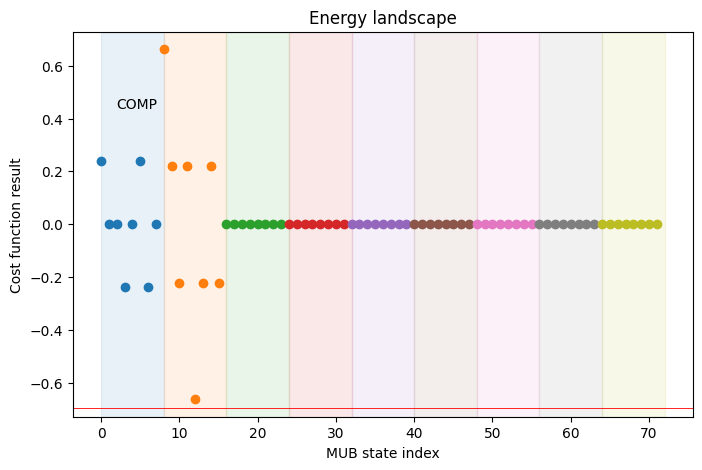

Energy Histogram:


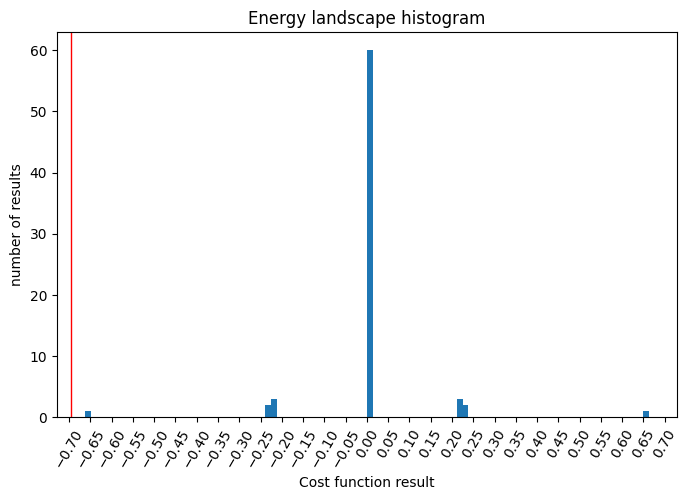

running from point with value -0.6624327278
(45, -0.6855297011179687, True)
-0.6944168033838574
running from point with value -0.2378414339
100: -0.6335402901210525
(157, -0.6850883152332364, True)
-0.6944168033838574
running from point with value -0.2378414339
100: -0.6646315958459976
(126, -0.6847503423741292, True)
-0.6944168033838574
running from point with value -0.2208109093
100: -0.3855295717090962
200: -0.6141161608954717
(291, -0.6868847784513488, True)
-0.6944168033838574
running from point with value -0.2208109093
100: -0.5905620863500585
(151, -0.6846271309209551, True)
-0.6944168033838574


In [42]:
# generate operator
n_qubits = 3
n_mub_qubits = 3
x_coeff = random.uniform(0,1)
zz_coeff = random.uniform(0,1)
op = gen_trans_ising_op(n_qubits, x_coeff, zz_coeff)
exact_result = get_exact_ground(op)

ansatz = TwoLocal(3, ['rx', 'ry', 'rz'], 'cx', 'linear', reps=3, insert_barriers=True).decompose()
zeroset_anastz = ansatz.assign_parameters([0.0]*ansatz.num_parameters)

# calculate landscape and graphs
results = calculate_energy_landscape(op, n_mub_qubits, generate_all_subsets(n_mub_qubits, n_qubits), appended_ansatz=zeroset_anastz)
exact_result = get_exact_ground(op)
print("Energy Landscape:")
display_energy_landscape(results, exact_result=exact_result)
print("Energy Histogram:")
display_energy_histogram(results, exact_result=exact_result)

# run VQE from the best 5 examples
params = get_standard_params(n_qubits)
params.success_bound = 1e-2
params.exact_result = exact_result
params.optimizer = 'BFGS'
params.report_period=100
params.report_thetas=False
for initial_state, value in find_k_best_results(results, 5):
    print(f"running from point with value {value}")
    print(run_vqe_experiment(op, ansatz, initial_state, params))
    print(params.exact_result)

## Example: generate operator, calculate landscape, show results

In [16]:
n_qubits = 3
n_mub_qubits = 3

zz_coeff = random.uniform(0,1)
x_coeff = random.uniform(0,1)
op = gen_trans_ising_op(n_qubits, zz_coeff, x_coeff)
ansatz = TwoLocal(3, 'ry', 'cx', 'linear', reps=2, insert_barriers=True).decompose()
zeroset_anastz = ansatz.assign_parameters([0.0]*ansatz.num_parameters)
print(zeroset_anastz)
print(f"attempting all MUB states over the operator {op}")
results = calculate_energy_landscape(op, n_mub_qubits, generate_all_subsets(n_mub_qubits, n_qubits), appended_ansatz=zeroset_anastz)
exact_result = get_exact_ground(op)

     ┌───────┐ ░            ░ ┌───────┐ ░            ░ ┌───────┐
q_0: ┤ Ry(0) ├─░───■────────░─┤ Ry(0) ├─░───■────────░─┤ Ry(0) ├
     ├───────┤ ░ ┌─┴─┐      ░ ├───────┤ ░ ┌─┴─┐      ░ ├───────┤
q_1: ┤ Ry(0) ├─░─┤ X ├──■───░─┤ Ry(0) ├─░─┤ X ├──■───░─┤ Ry(0) ├
     ├───────┤ ░ └───┘┌─┴─┐ ░ ├───────┤ ░ └───┘┌─┴─┐ ░ ├───────┤
q_2: ┤ Ry(0) ├─░──────┤ X ├─░─┤ Ry(0) ├─░──────┤ X ├─░─┤ Ry(0) ├
     └───────┘ ░      └───┘ ░ └───────┘ ░      └───┘ ░ └───────┘
attempting all MUB states over the operator SparsePauliOp(['ZZI', 'IZZ', 'XII', 'IXI', 'IIX'],
              coeffs=[0.28773921+0.j, 0.28773921+0.j, 0.36427212+0.j, 0.36427212+0.j,
 0.36427212+0.j])


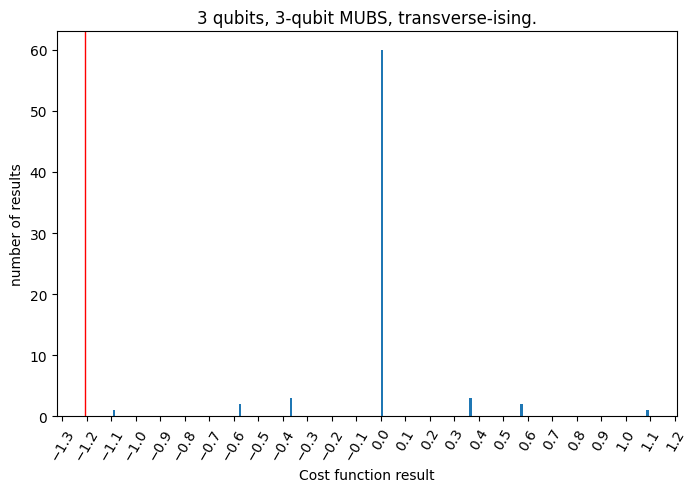

In [17]:
display_energy_histogram(results, exact_result, graph_title=f"{n_qubits} qubits, {n_mub_qubits}-qubit MUBS, transverse-ising.", bins=200)

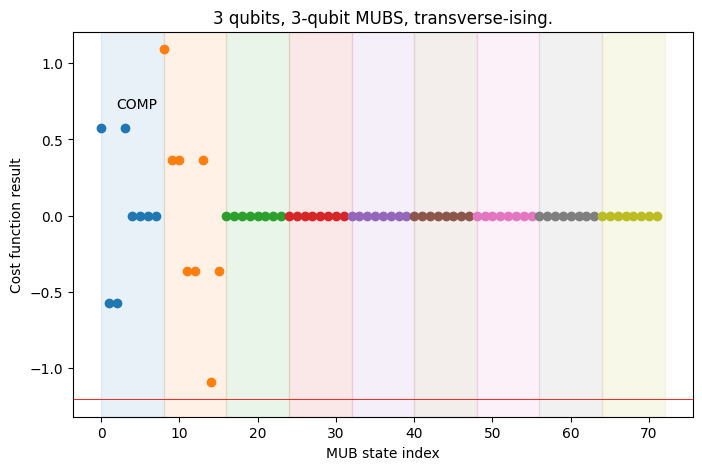

In [18]:
display_energy_landscape(results, exact_result, graph_title=f"{n_qubits} qubits, {n_mub_qubits}-qubit MUBS, transverse-ising.")

## Convincing results
What results dfo I want o show Tal and Dekel so they'll be convicned that what I did here shows anything?

1.  Show that when genrating 3-qubit full-MUB states using Trasnverse Ising, the best starting points are *clearly* not in the comp. basis.
    Do so by giving 2-3 examples of such generated Hamiltonians.

2.  Show that the rest of the results bunch around a VERY specific area in the cost, perhaps indicating a BP.
    Another, more pessimistic way to see this is that MUBs only give an advantage in a very small number of cases.
    Use the same graphs.

3.  Show that when we do Half-MUBs, the answers drastically drift away from the correct result. However, non-comps still lead to victory.
    Do so by giving 4-5 graphs with increasing qubit count, showing the distinct difference.

In [ ]:
# 3-qubit experiments
n_qubits = 3
n_mub_qubits = 3

for _ in range(3):  # Three examples
    zz_coeff = random.uniform(0,1)
    x_coeff = random.uniform(0,1)
    op = gen_trans_ising_op(n_qubits, zz_coeff, x_coeff)
    print(f"attempting all MUB states over the operator {op}")
    results = calculate_energy_landscape(op, n_mub_qubits, generate_all_subsets(n_mub_qubits, n_qubits))
    exact_result = get_exact_ground(op)
    print("Energy Landscape:")
    display_energy_landscape(results, exact_result=exact_result)
    print("Energy Histogram:")
    display_energy_histogram(results, exact_result=exact_result)

In [ ]:
# half-MUB experiments
n_mub_qubits = 3
zz_coeff = random.uniform(0,1)
x_coeff = random.uniform(0,1)

for n_qubits in range(4,8):  # Three examples

    op = gen_trans_ising_op(n_qubits, zz_coeff, x_coeff)
    print(f"attempting all MUB states over the operator {op}")
    results = calculate_energy_landscape(op, n_mub_qubits, generate_all_subsets(n_mub_qubits, n_qubits))
    exact_result = get_exact_ground(op)
    print("Energy Landscape:")
    display_energy_landscape(results, exact_result=exact_result)
    print("Energy Histogram:")
    display_energy_histogram(results, exact_result=exact_result)

### Unified results: partial-MUB with $\ket{0}$ vs. $\ket{+}$
Here, I run the same experiment with a bit less qubits, but use both options forn qubits not involved in the MUB state itself.
1.  Put it in $\ket{0}$, the trivial option.
2.  Put it in $\ket{+}$, the other option Dekel found to be rather successful.

In [ ]:
# half-MUB experiments
n_mub_qubits = 3
zz_coeff = random.uniform(0,1)
x_coeff = random.uniform(0,1)

print("THE ZERO EXPERIMENTS START")
for n_qubits in range(4,7):  # Three examples
    op = gen_trans_ising_op(n_qubits, zz_coeff, x_coeff)
    print(f"attempting all MUB states over the operator {op}")
    print("========ZERO VERSION=========")
    results = calculate_energy_landscape(op, n_mub_qubits, generate_all_subsets(n_mub_qubits, n_qubits))
    exact_result = get_exact_ground(op)
    print("Energy Landscape:")
    display_energy_landscape(results, exact_result=exact_result)
    print("Energy Histogram:")
    display_energy_histogram(results, exact_result=exact_result)
    print("========PLUS VERSION=========")
    results = calculate_energy_landscape(op, n_mub_qubits, generate_all_subsets(n_mub_qubits, n_qubits), plus_for_non_mub=True)
    exact_result = get_exact_ground(op)
    print("Energy Landscape:")
    display_energy_landscape(results, exact_result=exact_result)
    print("Energy Histogram:")
    display_energy_histogram(results, exact_result=exact_result)
    print("==============END============")
